<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC3000 Lab Group:SCSB , Group 5

Lim En Jia (U2320279L)
- Building RL agent (Q-Learnng)
- Collects and observes data to formulate results
- Documentations


Lee Jia Rong (U2322725D)
- Building RL agent (Q-Learnng)
- Collects and observes data to formulate results
- Documentations


Ng Zi Yuan (U2321488D)
- Building RL agent (Q-Learnng)
- Collects and observes data to formulate results
- Documentations


## Importing Dependencies and Define Helper Functions

In [22]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from gymnasium import logger as gymlogger
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import logging

#Function to display a recorded video from the 'video/' directory
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video).decode('ascii')
        display_html = f'''
        <video alt="Recorded video" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
        '''
        ipythondisplay.display(HTML(display_html))
    else: 
        print("⚠️ Could not find any video in the 'video/' folder.")


## Tutorial: Loading CartPole environment

In [23]:
env = gymnasium.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


### Action Space:
We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

The observation space is given below. The first two arrays define the minimum and maximum values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [24]:
observation = env.reset()
print("initial observation", observation)
print("actionSpace{}".format(env.action_space))
print("actionSpace{}".format(env.observation_space))

initial observation (array([-0.02469873,  0.04792952,  0.0465314 ,  0.02677745], dtype=float32), {})
actionSpaceDiscrete(2)
actionSpaceBox([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [25]:
observation, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Done?", done)


New observations after choosing action 0: [-0.02374014 -0.14782777  0.04706695  0.33377084]
Reward for this step: 1.0
Done? False


from this we can see that the agent has successfully balanced the pole for this time step and has been awarded a reward of 1, while the episiode is still running (not failed / achieved goal)

## Using Naive Strategy

Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [26]:
observation, info = env.reset()
cumulative_reward = 0
terminated = False
truncated = False

while not (terminated or truncated):
    observation, reward, terminated, truncated, info = env.step(0)
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)


Cumulative reward for this round: 10.0


# Task 1: Development of an RL agent - Q Learning Algorithm


# Initialization of parameters

## Number of Bins
Due to different levels of sensitivity of the 4 variables, the number of bins allocated varies.
A variable's sensitivity depends on whether small changes to its value affect the environment's behavior greatly.
The more sensitive the variable, the higher the number of bins

### 1. Cart Position
- Sensitivity: Low  
- There is a lot of room for the cart to move, so small errors don’t matter much.  
- 6 bins are sufficient.

### 2. Cart Velocity
- Sensitivity: Low  
- Velocity changes are easy to correct and do not cause immediate failure.  
- 6 bins are sufficient.

### 3. Pole Angle (θ)
- Sensitivity: Medium to High  
- Small angle changes quickly cause instability, requiring precise control.  
- 12 bins are used for finer resolution.

### 4. Pole Angular Velocity (θ′)
- Sensitivity: Very High  
- Small changes lead to immediate tipping, making it the most critical variable.  
- 50 bins are required for high precision.



## Lower and Upper Bounds
Based on observation space of the environment
These define the minimum and maximum values each state variable can take.  
Used to calculate bin sizes and map continuous states to discrete bins.

## Bin Sizes Calculation
To ensure that every bin covers an equal portion of the variable's range

## Initializing of Q-Table
### What is the Q-Table?
Each state (cart position, velocity, pole angle, pole angular velocity) is represented as a discrete index (after discretization)

Each action has a Q-value -> to show how good the action is in that particular state
- The Q-table stores estimated Q-values for each discrete state-action pair.
- Each state is represented by a tuple of discrete indices from binning the 4 state variables.
- Each state has an associated list of Q-values for the possible actions.


Q-values are updated over time through Q-learning.

## Constant Variables

These hyperparameters define the learning behavior and exploration strategy of the Q-learning agent.

### LEARNING_RATE
- Value: `0.1`
- Description: The learning rate (α).  
  Determines how much new Q-value estimates affect existing ones.  
  A lower value results in slower, more stable learning, while a higher value can speed up learning but risks instability.

### DISCOUNT
- Value: `0.95`
- Description: The discount factor (γ).  
  Determines the importance of future rewards.  
  A value close to 1 prioritizes long-term rewards, while lower values make the agent more short-sighted.

### EPISODES
- Value: `15000`
- Description: Total number of episodes the agent will be trained.  
  Based on testing:
  - Less than 10,000 episodes typically leads to **undertraining**
  - More than 20,000–30,000 episodes can lead to **overtraining**
  - 15,000 is the chosen **sweet spot** for balanced learning.

---

## Exploration Parameters

These control the agent's exploration-exploitation tradeoff using the ε-greedy strategy.

### epsilon
- Initial Value: `1.0`
- Description: Starting exploration rate (ε).  
  The agent explores completely randomly at the beginning to gather diverse experiences.

### epsilon_decay
- Value: `0.99944`
- Description: The decay rate applied to epsilon after each episode.  
  Gradually reduces exploration, allowing the agent to shift towards exploitation of learned policies.

### min_epsilon
- Value: `0.01`
- Description: The minimum value that epsilon can decay to.  
  Ensures that the agent continues exploring at least 1% of the time, preventing it from getting stuck in local optima.


Number of Bins
Due to different levels of sensitivity of the 4 state variables, the number of bins allocated to each varies.

In [27]:
# Parameters
LEARNING_RATE = 0.1 # Learning rate for Q-learning
DISCOUNT = 0.95     # Discount factor for future rewards
EPISODES = 15000    # Total number of episodes to train agent
# from what we tested, <10k leads to undertraining
# and >20-30k leads to overtraining

epsilon = 1.0
epsilon_decay = 0.99944
min_epsilon = 0.01
print("initial observation", observation)
print("actionSpace{}".format(env.action_space))
print("actionSpace{}".format(env.observation_space))
# State space discretization
bins = [6, 6, 12, 50]

lower_bounds = np.array([-4.8, -5.0, -0.418, -5.0])
upper_bounds = np.array([4.8, 5.0, 0.418, 5.0])

bin_sizes = (upper_bounds - lower_bounds) / bins

# Q-table
q_table = np.random.uniform(low=0, high=1, size=(bins + [env.action_space.n]))

initial observation [-0.12551722 -1.9453578   0.24157816  3.0763042 ]
actionSpaceDiscrete(2)
actionSpaceBox([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


### Convert the next continuous state into a discrete state.


In [28]:
def get_discrete_state(state):
    clipped = np.clip(state, lower_bounds, upper_bounds)
    discrete = ((clipped - lower_bounds) / bin_sizes)
    discrete = np.clip(discrete, 0, np.array(bins) - 1).astype(int) 
    return tuple(discrete)


For Task 1, we can show the observation and chosen action below:

In [29]:
rewards_per_episode = []


# Q-Learning Training Loop

The training loop is responsible for running the agent through multiple episodes to learn optimal behavior.

---

## Episode Loop

- Iterate through each episode (total defined by `EPISODES`)
- At the start of each episode:
  - Reset the environment to get the initial state
  - Discretize the continuous state into a discrete index using predefined bins
  - Initialize `episode_reward = 0` to track total reward
  - Initialize flags to monitor if the episode ends (e.g., done or truncated)

The episode continues until it reaches a terminal or truncated state.

---

## Epsilon-Greedy Action Selection

This strategy helps balance **exploration** (trying new actions) and **exploitation** (using the best-known action).

### Exploration
- If a random number `< epsilon`, the agent **explores**:
  - Choose a random action from the environment’s action space

### Exploitation
- Otherwise, the agent **exploits**:
  - Select the action with the **highest Q-value** from the Q-table for the current state

---

## Environment Interaction

- The selected action is applied to the environment
- The agent receives:
  - `next_state`: the resulting state
  - `reward`: immediate reward for the action
  - `done`: flag indicating whether the episode has ended
- The next continuous state is then discretized for further Q-table updates

---

This loop continues until the episode ends, and the agent updates its Q-values accordingly.


#### Resetting initial environment for cartpole

In [30]:
env = gymnasium.make("CartPole-v1")


In [31]:
for episode in range(EPISODES):
    state, _ = env.reset()

    discrete_state = get_discrete_state(state)
    total_reward = 0
    done = False
    terminated = False
    truncated = False


    while not (terminated or truncated):
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[discrete_state])

        # next_state, reward, done, _, _ = env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # move to the next state
        next_discrete_state = get_discrete_state(next_state)

        # retrieve the maximum Q-value for the next state
        # get the current Q-value for the taken action

        max_future_q = np.max(q_table[next_discrete_state])
        current_q = q_table[discrete_state + (action,)]
        
        # update Q-table using Bellman Equation
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[discrete_state + (action,)] = new_q

        discrete_state = next_discrete_state
        total_reward += reward

    # decay epsilon for exploration-exploitation trade-off
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay
        epsilon = max(min_epsilon, epsilon)

    # accumulate reward for performance tracking
    # store total reward for analysis
    rewards_per_episode.append(total_reward)

    # print progress every 500 episodes
    if episode % 500 == 0:
        avg = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode} | Avg Reward (last 100): {avg:.2f} | Epsilon: {epsilon:.4f}")

Episode 0 | Avg Reward (last 100): 26.00 | Epsilon: 0.9994
Episode 500 | Avg Reward (last 100): 25.09 | Epsilon: 0.7553
Episode 1000 | Avg Reward (last 100): 46.59 | Epsilon: 0.5708
Episode 1500 | Avg Reward (last 100): 106.58 | Epsilon: 0.4314
Episode 2000 | Avg Reward (last 100): 178.78 | Epsilon: 0.3260
Episode 2500 | Avg Reward (last 100): 280.17 | Epsilon: 0.2464
Episode 3000 | Avg Reward (last 100): 333.66 | Epsilon: 0.1862
Episode 3500 | Avg Reward (last 100): 405.05 | Epsilon: 0.1407
Episode 4000 | Avg Reward (last 100): 419.10 | Epsilon: 0.1063
Episode 4500 | Avg Reward (last 100): 316.85 | Epsilon: 0.0804
Episode 5000 | Avg Reward (last 100): 303.14 | Epsilon: 0.0607
Episode 5500 | Avg Reward (last 100): 350.02 | Epsilon: 0.0459
Episode 6000 | Avg Reward (last 100): 227.12 | Epsilon: 0.0347
Episode 6500 | Avg Reward (last 100): 171.47 | Epsilon: 0.0262
Episode 7000 | Avg Reward (last 100): 253.67 | Epsilon: 0.0198
Episode 7500 | Avg Reward (last 100): 386.89 | Epsilon: 0.0150

In [32]:
def Reinforcement_Learning_agent(state):
    discrete_state=get_discrete_state(state)
    action = np.argmax(q_table[discrete_state]) 
    return action

## Task 2: Demonstrate the effectiveness of the RL agent

This is done by printing the cumulative rewards after each run

In [33]:
env = gymnasium.make("CartPole-v1")
test_episodes=100
episode_results = []
cumulative_reward_results = int(0)
for test_episode in range(test_episodes):
    observation, info = env.reset()
    state = observation

    cumulative_reward = 0
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = Reinforcement_Learning_agent(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        cumulative_reward += reward
        cumulative_reward_results+=reward
        
    episode_results.append(cumulative_reward)
    print(f"Cumulative reward for round {test_episode + 1}: {cumulative_reward}")


Cumulative reward for round 1: 500.0
Cumulative reward for round 2: 500.0
Cumulative reward for round 3: 500.0
Cumulative reward for round 4: 500.0
Cumulative reward for round 5: 500.0
Cumulative reward for round 6: 500.0
Cumulative reward for round 7: 500.0
Cumulative reward for round 8: 500.0
Cumulative reward for round 9: 500.0
Cumulative reward for round 10: 500.0
Cumulative reward for round 11: 500.0
Cumulative reward for round 12: 500.0
Cumulative reward for round 13: 500.0
Cumulative reward for round 14: 500.0
Cumulative reward for round 15: 500.0
Cumulative reward for round 16: 500.0
Cumulative reward for round 17: 500.0
Cumulative reward for round 18: 500.0
Cumulative reward for round 19: 500.0
Cumulative reward for round 20: 500.0
Cumulative reward for round 21: 500.0
Cumulative reward for round 22: 500.0
Cumulative reward for round 23: 500.0
Cumulative reward for round 24: 500.0
Cumulative reward for round 25: 500.0
Cumulative reward for round 26: 500.0
Cumulative reward for

Plot the cumulative reward against all episodes 

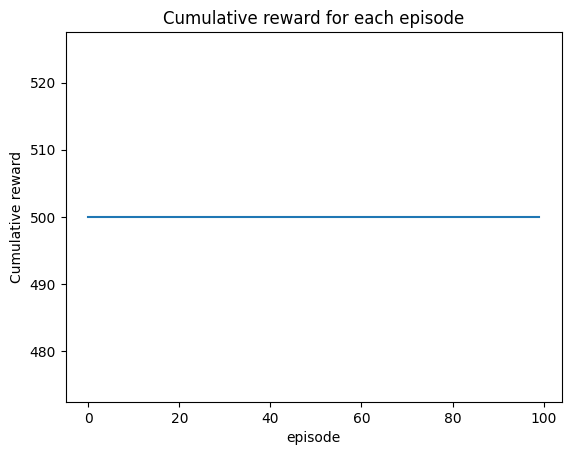

In [34]:
plt.plot(episode_results)

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [35]:
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [36]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import random

# Create environment with correct render mode
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Wrap it to record video
env = RecordVideo(env, video_folder="./video")

# Reset environment and unpack the new return format
observation, info = env.reset()

cumulative_reward = 0
terminated = False
truncated = False

while not (terminated or truncated):
        action = Reinforcement_Learning_agent(state)
        
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        cumulative_reward += reward
        cumulative_reward_results+=reward

env.close()

print("Cumulative reward:", cumulative_reward)

# Show video if you're in Jupyter
show_video()


c:\Users\calvi\source\repos\SC3000_team5\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\calvi\source\repos\SC3000_team5\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Cumulative reward: 500.0
